# **Project 2**, APS1070 Fall 2021
**Anomaly Detection Algorithm using Gaussian Mixture Model [13 Marks]**

**Deadline: OCT 22, 9 PM**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Name: Kaiyan Jiang
*   Student Number: 1003848189

##**Part 1: Getting started [1.5 Marks]**

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there? 284807 **[0.1]**
* What features in the dataset are present aside from the 28 main features?  Time, Amount, Class **[0.1]**
* Which column contains the targets? Class**[0.1]**
* To what do the target values correspond? 0 represents Valid, 1 represents Fraud **[0.1]**

In [1]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=17d0093fa671fb2a66b16e2580f79a2eaa943998abc7f5326f4f6122eb617713
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [3]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [5]:
len(df.index)

284807

In [6]:
print(df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')



* What is the percentage of entries in the dataset for each class? **[0.1]**  
The percentage of 0(Valid) is approximately 99.83%  
The percentage of 1(Fraud) is approximately 0.17% 
* Is this data considered balanced or unbalanced? Why is this the case? **[0.1]**  
The data is unbalanced.  
Because we can see there is a high difference between the valid cases and the fraud cases. 
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1? **[0.2]**   
  In the KNN classifier, we aim to classify the point with the majority group of the k nearest neighbours. Once the data is unbalanced, the group with more examples likely occurs more in the k nearest neighbours. So we may misclassify the point.  



In [7]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
print(round(sum(df['Class']==0)/len(df.index)*100,2),'%')

99.83 %


In [9]:
print(round(sum(df['Class']==1)/len(df.index)*100,2),'%')

0.17 %


Next, split the dataset into a training (70%), validation (15%) and testing set (15%). Set the random state to 0. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [10]:
### Split the data  ###
from sklearn.model_selection import train_test_split

X = df.iloc[:,0:30]
y = df.iloc[:,30]

X, X_test, y, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15/0.85, random_state=0)

Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

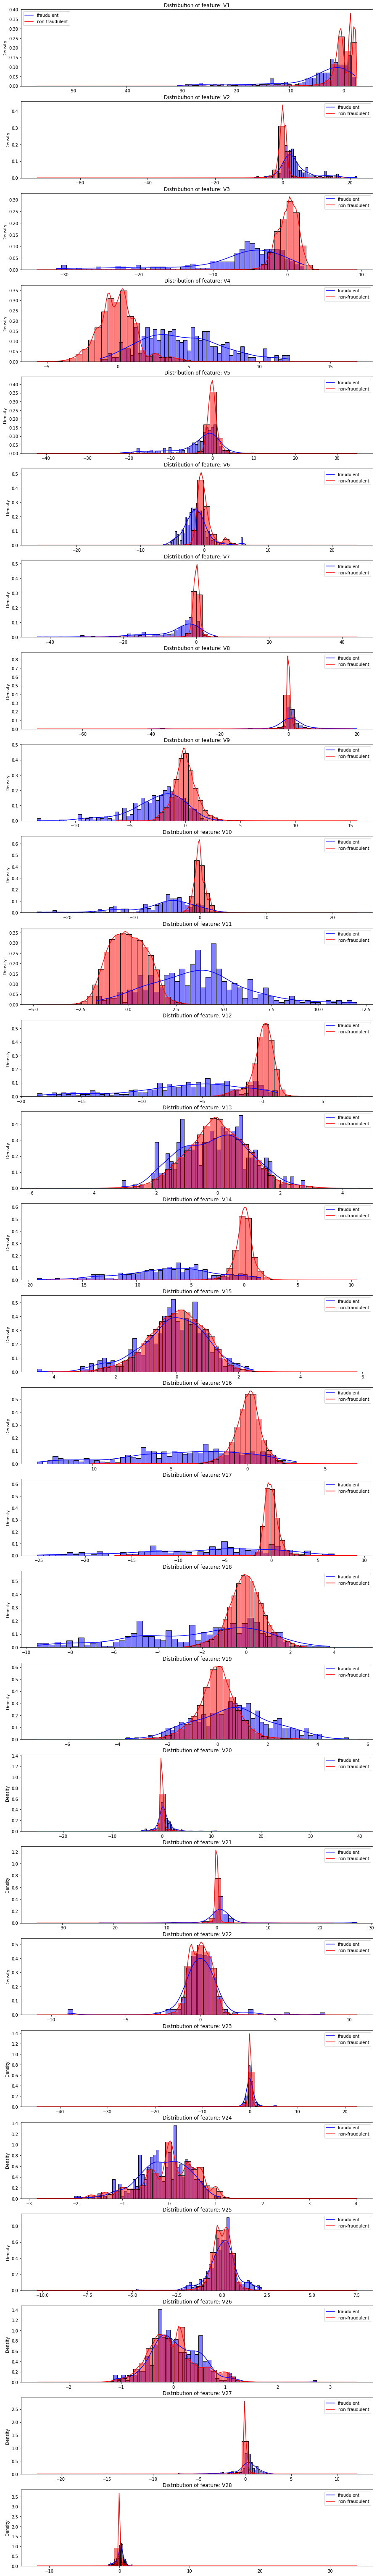

In [11]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**

The distribution graphs of non-fraudulent and fraudulent data for each features show the distribution of our data close to the gaussian distributions.  
From the above graphs, features with more data show a more clearly Gaussian distribution and for these features, the accuracy might be higher in model-fitting.  
And generally, the non-fraudulent data for each features are centered at 0, where the data is very close to standardized data. While the fraudulent data are centered at zero for some features and some are not. The features with great difference between the mean of non-fraudulent and the mean of fraudulent data could be more helpful in anomaly detection.  

## **Part 2: Single feature model with one Gaussian distribution: [2.5 Marks]**
We'll start by making a prediction using **a single feature of our dataset at a time**. 

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table. 
  4. Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set. **[0.2]**
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`. **[0.5]**
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.**[0.5]**

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a. 
 2. Compute AUC and F1 score when you fit a Gaussian **only on non-fraudulent transactions** (instead of all the transactions).
 3. Compare your results from parts 2a and 2b (AUC and F1 score) in a table. **[0.8]**
 4. Are these results different or similar? Why?**[0.5]**





Part 2 (a)  

Step 1-3:

In [12]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from astropy.table import QTable, Table, Column

## Code From: https://docs.astropy.org/en/stable/table/construct_table.html

In [127]:
def singleGaussian (x_train, x_val, y_train, y_val):
  features = [f for f in x_train.columns if 'V' in f]

  index = []
  auc_train = []
  auc_val = []

  for i, feat in enumerate(features):
    index.append(i+1)

    x_train_new = x_train.iloc[:,i+1]
    x_train_new = np.array(x_train_new).reshape(-1,1)

    x_val_new = x_val.iloc[:,i+1]
    x_val_new = np.array(x_val_new).reshape(-1,1)

    gm = GaussianMixture(n_components=1,covariance_type='full',random_state=0)
    gm.fit(x_train_new)
    

    sc = gm.fit(x_train_new).score_samples(x_train_new)
    sc_val = gm.fit(x_train_new).score_samples(x_val_new)

    fpr_sc, tpr_sc, _ = roc_curve(y_train, 1-sc)
    fpr_sc_val, tpr_sc_val, _ = roc_curve(y_val, 1-sc_val)

    auc_train.append(auc(fpr_sc, tpr_sc))
    auc_val.append(auc(fpr_sc_val, tpr_sc_val))

  Results = Table([index, auc_train, auc_val], names=("Features","AUC of Train","AUC of Validation"))

  return Results

In [128]:
Result1 = singleGaussian(X_train,X_val,y_train,y_val)

In [161]:
print(tabulate(Result1,tablefmt='markdown',headers='keys'))

  Features    AUC of Train    AUC of Validation
----------  --------------  -------------------
         1        0.704715             0.731833
         2        0.848104             0.837961
         3        0.880042             0.832369
         4        0.894416             0.871487
         5        0.760907             0.816581
         6        0.734653             0.721507
         7        0.862982             0.872639
         8        0.772515             0.828098
         9        0.799795             0.820999
        10        0.911624             0.914375
        11        0.898589             0.904493
        12        0.912838             0.928006
        13        0.560512             0.603536
        14        0.94974              0.955297
        15        0.52628              0.449022
        16        0.898402             0.913098
        17        0.927538             0.925703
        18        0.802886             0.768276
        19        0.741973             0

Step 4:

In [16]:
import heapq

In [17]:
heapq.nlargest(3,Result1['AUC of Validation'])

#Code From: https://stackoverflow.com/questions/10152131/how-do-i-index-the-3-highest-values-in-a-list

[0.9552970953177244, 0.9280062095946573, 0.9257025422574674]

In [18]:
Num_of_Features = [[i+1 for i,l in enumerate(Result1) if 0.9552970953177244 in l ],
                   [i+1 for i,l in enumerate(Result1) if 0.9280062095946573 in l ], 
                   [i+1 for i,l in enumerate(Result1) if 0.9257025422574674 in l ]]
Num_of_Features

#Code From: https://stackoverflow.com/questions/18596648/table-column-count-searching-for-a-value-in-python

[[14], [12], [17]]

In [92]:
Num_of_Features[1][0]

12

In [97]:
print('The best three features are V'+ str(Num_of_Features[0][0]),
      ', V'+str(Num_of_Features[1][0]),'and V'+str(Num_of_Features[2][0]),
      'with corresponding AUC:',heapq.nlargest(3,Result1['AUC of Validation']))

The best three features are V14 , V12 and V17 with corresponding AUC: [0.9552970953177244, 0.9280062095946573, 0.9257025422574674]


Step 5:

In [19]:
from sklearn.metrics import f1_score
from matplotlib import pyplot

In [98]:
def thresholdF1 (x_train, x_val ,y_val):

  gm = GaussianMixture(n_components=1,covariance_type='full',random_state=0)
  gm.fit(x_train)

  sc = gm.fit(x_train).score_samples(x_val)

  fpr, tpr, _ = roc_curve(y_val, 1-sc)

  F1_list1000 = []

  for i in range(0,len(sc),1000):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_val,new_list)
    F1_list1000.append(F1)
  
  F1_max1000 = max(F1_list1000)
  F1_index1000 = F1_list1000.index(F1_max1000)

  F1_list100 = []

  for i in range(0,F1_index1000*1000+1,100):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_val,new_list)
    F1_list100.append(F1)
  
  F1_max100 = max(F1_list100)
  F1_index100 = F1_list100.index(F1_max100)

  F1_list10 = []

  for i in range(0,F1_index100*100+1,10):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_val,new_list)
    F1_list10.append(F1)
  
  F1_max10 = max(F1_list10)
  F1_index10 = F1_list10.index(F1_max10)
  
  F1_list = []

  for i in range(0,F1_index10*10+1):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_val,new_list)
    F1_list.append(F1)
  
  F1_max = max(F1_list)
  F1_index = F1_list.index(F1_max)
  return [sorted(sc)[F1_index], F1_max]

In [99]:
X_train_14 = X_train.iloc[:,14]
X_train_14 = np.array(X_train_14).reshape(-1,1)

X_train_12 = X_train.iloc[:,12]
X_train_12 = np.array(X_train_12).reshape(-1,1)

X_train_17 = X_train.iloc[:,17]
X_train_17 = np.array(X_train_17).reshape(-1,1)

In [100]:
X_val_14 = X_val.iloc[:,14]
X_val_14 = np.array(X_val_14).reshape(-1,1)

X_val_12 = X_val.iloc[:,12]
X_val_12 = np.array(X_val_12).reshape(-1,1)

X_val_17 = X_val.iloc[:,17]
X_val_17 = np.array(X_val_17).reshape(-1,1)

In [101]:
Result = [thresholdF1(X_train_14,X_val_14,y_val),thresholdF1(X_train_12,X_val_12,y_val),thresholdF1(X_train_17,X_val_17,y_val)]
Result

[[-23.083734928584178, 0.6218487394957983],
 [-12.154129808866921, 0.6285714285714286],
 [-21.823881250748027, 0.5614035087719298]]

Step 6:

In the process determining the optimal threshold, I used 4 loops with different step in *range( )*.  
For each loop, the time complexity is $O(n^2)$. Hence for the whole process, the complexity would be $4O(n^2)$, which is also bounded by $O(n^2)$.  
Therefore, the time complexity of the process determining the optimal threshold is $O(n^2)$.  



Part b

Step 1-3:

In [24]:
combined = pd.concat([X_train,y_train],axis=1)
combined = combined.loc[combined['Class'] == 0]

In [25]:
X_train_non = combined.iloc[:,0:30]
y_train_non = combined.iloc[:,30]

In [26]:
X_14 = X_train_non.iloc[:,14]
X_14 = np.array(X_14).reshape(-1,1)

X_12 = X_train_non.iloc[:,12]
X_12 = np.array(X_12).reshape(-1,1)

X_17 = X_train_non.iloc[:,17]
X_17 = np.array(X_17).reshape(-1,1)

In [102]:
def function2 (x_train,x_val,y_val):

  gm = GaussianMixture(n_components=1,covariance_type='full',random_state=0)
  gm.fit(x_train)

  sc = gm.fit(x_train).score_samples(x_val)

  fpr, tpr, _ = roc_curve(y_val, 1-sc)

  auc1 = auc(fpr, tpr)

  F1_list1000 = []

  for i in range(0,len(sc),1000):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_val,new_list)
    F1_list1000.append(F1)
  
  F1_max1000 = max(F1_list1000)
  F1_index1000 = F1_list1000.index(F1_max1000)

  F1_list100 = []

  for i in range(0,F1_index1000*1000+1,100):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_val,new_list)
    F1_list100.append(F1)
  
  F1_max100 = max(F1_list100)
  F1_index100 = F1_list100.index(F1_max100)

  F1_list10 = []

  for i in range(0,F1_index100*100+1,10):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_val,new_list)
    F1_list10.append(F1)
  
  F1_max10 = max(F1_list10)
  F1_index10 = F1_list10.index(F1_max10)
  
  F1_list = []

  for i in range(0,F1_index10*10+1):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_val,new_list)
    F1_list.append(F1)
  
  F1_max = max(F1_list)
  F1_index = F1_list.index(F1_max)
  return [auc1, sorted(sc)[F1_index], F1_max]

In [103]:
Results = [function2(X_train_14,X_val_14,y_val),function2(X_train_12,X_val_12,y_val),function2(X_train_17,X_val_17,y_val)]
Results

[[0.9552970953177244, -23.083734928584178, 0.6218487394957983],
 [0.9280062095946573, -12.154129808866921, 0.6285714285714286],
 [0.9257025422574674, -21.823881250748027, 0.5614035087719298]]

In [104]:
Results_non = [function2(X_14,X_val_14,y_val), function2(X_12,X_val_12,y_val), function2(X_17,X_val_17, y_val)]
Results_non

[[0.9560613874693298, -26.08433773803603, 0.6218487394957983],
 [0.9283701228002414, -13.476823057331078, 0.6285714285714286],
 [0.9264757647944858, -27.768574194302523, 0.5614035087719298]]

In [117]:
from tabulate import tabulate

In [160]:
R1 = pd.DataFrame(np.concatenate([Results,Results_non]),columns=['Auc','Optimal Threshold','F1 Score'],
                  index=['All Class V14','All Class V12','All Class V17',
                         'Non-Fraudulent V14','Non-Fraudulent V12','Non-Fraudulent V17'])
print(tabulate(R1,tablefmt='markdown', headers="keys"))

## Code From: https://stackoverflow.com/questions/45399950/how-to-create-a-pandas-dataframe-with-several-numpy-1d-arrays

                         Auc    Optimal Threshold    F1 Score
------------------  --------  -------------------  ----------
All Class V14       0.955297             -23.0837    0.621849
All Class V12       0.928006             -12.1541    0.628571
All Class V17       0.925703             -21.8239    0.561404
Non-Fraudulent V14  0.956061             -26.0843    0.621849
Non-Fraudulent V12  0.92837              -13.4768    0.628571
Non-Fraudulent V17  0.926476             -27.7686    0.561404


Step 4:

From the above table, the results are similar.  
However, we can observe that the AUC values when fitting the models on non-fraudulent transactions are slightly higher than the AUC values when fitting the models on all transactions.  
This may due to when fitting the models on non-fraudulent transactions, the non-fraudulent transactions can be more clearly classified. The the number of true negative is higher, so the false positive rate decreases which leads to a higher AUC value.  
On the other hand, the F1 scores when fitting different transactions are the same. This may because that our data is very unbalanced. The amount of valid transactions are much more than fraud transactions. So the non-fraudulent transactions accounts most of our data. When only fitting on non-fraudulent transactions, the abiliy to distinguish fraud transaction will not have a clear difference. So the F1 scores are the same.  

## **Part 3: Multiple feature model with one Gaussian distribution: [1 Marks]**
This part is similar to Part 2, but we will pick multiple features and **visually** set the number of components.

  a. 2D plot:
 1. Pick two features (say, f1 and f2). 
 2. Scatter plot (plt.scatter) those features on a figure (f1 on the x-axis and f2 on the y-axis). 
 3. Color the data points based on their class (non-fraudulent blue and fraudulent red).
 4. Based on your plots, decide how many Gaussian components (``n_components``) you need to fit the data (focus on valid transactions). Explain.  **[0.25]**
 5. Fit your Gaussian model on all the data points. 
 6. Compute AUC on both training and validation sets 
 7. Pick 3 new pairs of features and repeat steps 2 to 6. **[0.25]**
 8. For each pair, find a threshold to maximize your validation set F1 Score.**[0.25]**
 9. For each pair, plot a figure similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in the tutorial) **[0.25]**





Step 1-3:

In [31]:
import matplotlib.patches as mpatches

In [32]:
# Pick Feature V7 and V24
X_724 = X_train.iloc[:,[7,24]]
X_val_724 = X_val.iloc[:,[7,24]]

y_train_new = np.array(y_train)

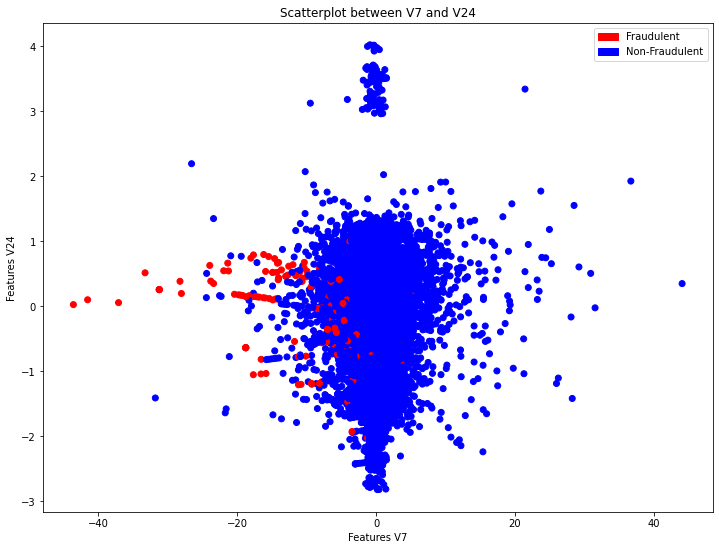

In [33]:
# Plot Scatter Plot 
col = np.where(y_train_new == 1,'r','b')

plt.figure(figsize=(12,9))

plt.scatter(X_724['V7'],X_724['V24'],c = col)

pop_a = mpatches.Patch(color='r', label='Fraudulent')
pop_b = mpatches.Patch(color='b', label='Non-Fraudulent')

plt.legend(handles=[pop_a,pop_b])

plt.title('Scatterplot between V7 and V24')
plt.xlabel('Features V7')
plt.ylabel('Features V24')

plt.show()

## Code From: https://moonbooks.org/Articles/How-to-add-a-legend-for-a-scatter-plot-in-matplotlib-/

Step 4-6:

From the above scatterplot, I think pick *n_components = 2* is appropriate. Because the valid transactions have two obvious clusters. One is when $V24 <= 2$ and the other is when $V24 > 2$.  



In [34]:
# Fit Gaussian Model with two components
gm = GaussianMixture(n_components=2,covariance_type='full',random_state=0)
gm.fit(X_724)

sc = gm.fit(X_724).score_samples(X_724)
sc_val = gm.fit(X_724).score_samples(X_val_724)

fpr_sc, tpr_sc, threshold_sc = roc_curve(y_train, 1-sc)
fpr_sc_val, tpr_sc_val,threshold_sc_val = roc_curve(y_val, 1-sc_val)

auc_train = auc(fpr_sc, tpr_sc)
auc_val = auc(fpr_sc_val, tpr_sc_val)
print('The AUC of training set is', auc_train, ', and the AUC of validation set is', auc_val)

The AUC of training set is 0.8425659282590305 , and the AUC of validation set is 0.8708770457094335


Step 7-9:

In [37]:
def function (x_train,x_val,y_val,num):

  gm = GaussianMixture(n_components=num,covariance_type='full',random_state=0)
  gm.fit(x_train)

  sc_train = gm.fit(x_train).score_samples(x_train)
  sc = gm.fit(x_train).score_samples(x_val)

  fpr, tpr, _ = roc_curve(y_val, 1-sc)

  F1_list1000 = []

  for i in range(1,len(sc),1000):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_val,new_list)
    F1_list1000.append(F1)
  
  F1_max1000 = max(F1_list1000)
  F1_index1000 = F1_list1000.index(F1_max1000)

  F1_list100 = []

  for i in range(1,F1_index1000*1000+1,100):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_val,new_list)
    F1_list100.append(F1)
  
  F1_max100 = max(F1_list100)
  F1_index100 = F1_list100.index(F1_max100)

  F1_list10 = []

  for i in range(1,F1_index100*100+1,10):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_val,new_list)
    F1_list10.append(F1)
  
  F1_max10 = max(F1_list10)
  F1_index10 = F1_list10.index(F1_max10)
  
  F1_list = []

  for i in range(1,F1_index10*10+1):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_val,new_list)
    F1_list.append(F1)
  
  F1_max = max(F1_list)
  F1_index = F1_list.index(F1_max)
  
  sorted(sc)[F1_index]

  return sc_train, sorted(sc)[F1_index], F1_max

In [35]:
# First Pair: Pick Feature V4 and V19
X_419 = X_train.iloc[:,[4,19]]
X_val_419 = X_val.iloc[:,[4,19]]

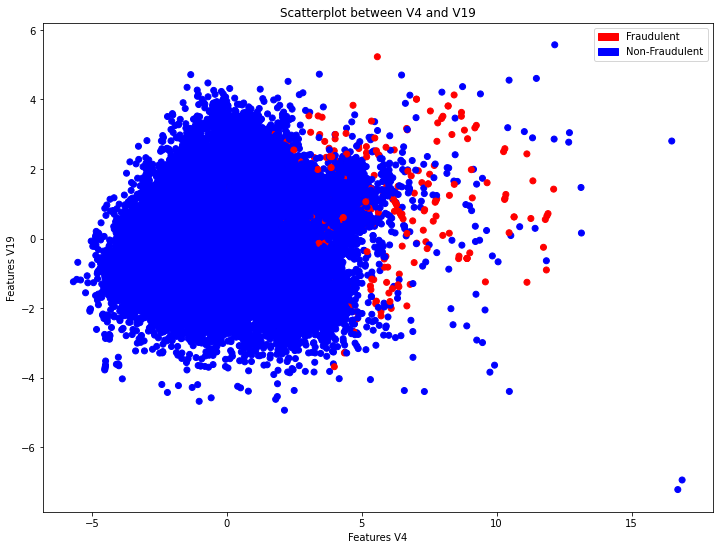

In [36]:
# Plot Scatter Plot 
col = np.where(y_train_new == 1,'r','b')

plt.figure(figsize=(12,9))

plt.scatter(X_419['V4'],X_419['V19'],c = col)

pop_a = mpatches.Patch(color='r', label='Fraudulent')
pop_b = mpatches.Patch(color='b', label='Non-Fraudulent')

plt.legend(handles=[pop_a,pop_b])

plt.title('Scatterplot between V4 and V19')
plt.xlabel('Features V4')
plt.ylabel('Features V19')

plt.show()

I think for feature V4 and feature V19, there seem to be two clusters. One is the cluster on the left side of the graph which contains most non-fraudulent transactions. The other contains some fraudulent and non-fraudulent transactions at the middle of the plot.   
So the *n_components = 2*.  

In [38]:
Pair1 = function(X_419,X_val_419,y_val,2)

In [39]:
outliers = np.nonzero(Pair1[0] < Pair1[1])[0]

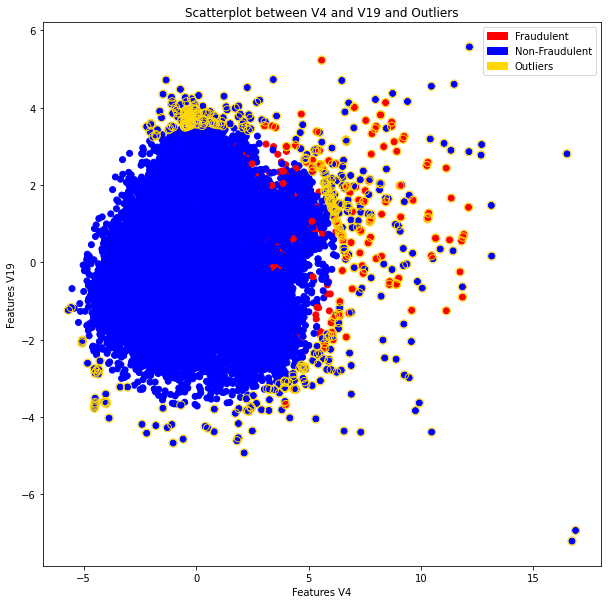

In [40]:
X_419 = np.array(X_419)
plt.figure(figsize=(10,10))

col = np.where(y_train_new == 1,'r','b')

plt.scatter(X_419[:,0],X_419[:,1],c = col)
plt.scatter(X_419[outliers,0],X_419[outliers,1],marker="o",facecolor= "none",edgecolor="gold",s=70)

pop_a = mpatches.Patch(color='r', label='Fraudulent')
pop_b = mpatches.Patch(color='b', label='Non-Fraudulent')
pop_c = mpatches.Patch(color='gold', label='Outliers')

plt.legend(handles=[pop_a,pop_b,pop_c])

plt.title('Scatterplot between V4 and V19 and Outliers')
plt.xlabel('Features V4')
plt.ylabel('Features V19')

plt.show()

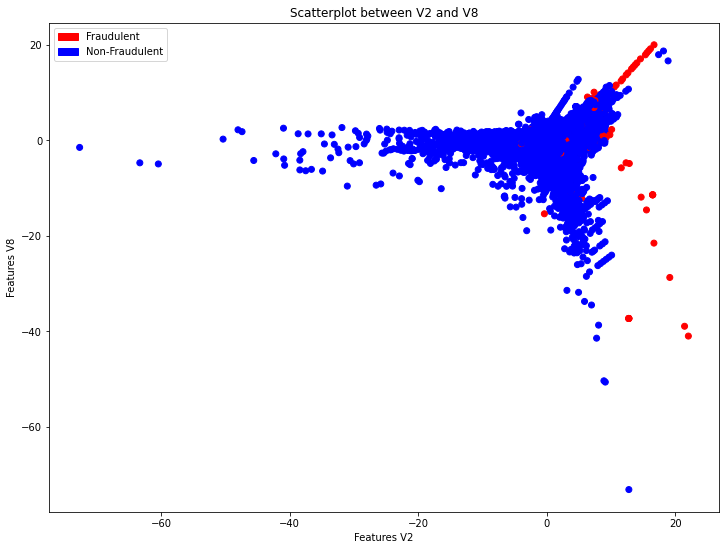

In [41]:
# Second Pair: Pick Feature V2 and V8
X_28 = X_train.iloc[:,[2,8]]
X_val_28 = X_val.iloc[:,[2,8]]

# Plot Scatter Plot 
col = np.where(y_train_new == 1,'r','b')

plt.figure(figsize=(12,9))

plt.scatter(X_28['V2'],X_28['V8'],c = col)

pop_a = mpatches.Patch(color='r', label='Fraudulent')
pop_b = mpatches.Patch(color='b', label='Non-Fraudulent')

plt.legend(handles=[pop_a,pop_b])

plt.title('Scatterplot between V2 and V8')
plt.xlabel('Features V2')
plt.ylabel('Features V8')

plt.show()

For feature V2 and feature V8, I pick *n_components=3* because I think there is three clusters in the graph. One is on the right upper corner and the second is the point where $V2>0$ and $V8< 0$, the third one is where $ V2< 0$ and $V8$ around 0.  

In [42]:
Pair2 = function(X_28,X_val_28,y_val,3)

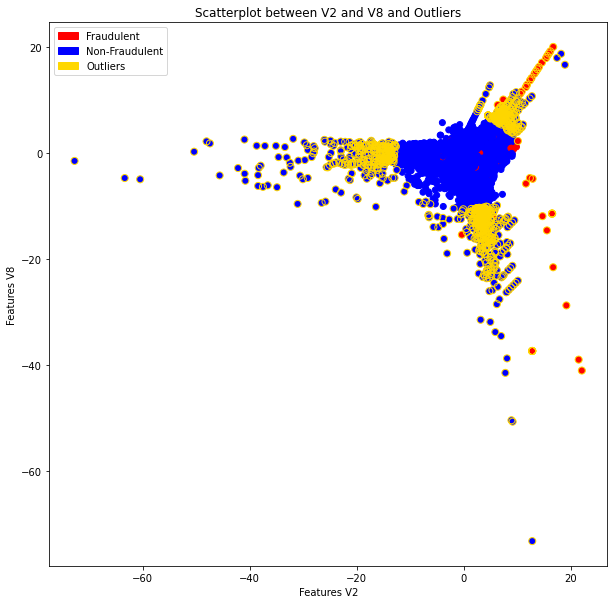

In [43]:
outliers = np.nonzero(Pair2[0]<Pair2[1])[0]
X_28 = np.array(X_28)
plt.figure(figsize=(10,10))

col = np.where(y_train_new == 1,'r','b')

plt.scatter(X_28[:,0],X_28[:,1],c = col)
plt.scatter(X_28[outliers,0],X_28[outliers,1],marker="o",facecolor= "none",edgecolor="gold",s=50)

pop_a = mpatches.Patch(color='r', label='Fraudulent')
pop_b = mpatches.Patch(color='b', label='Non-Fraudulent')
pop_c = mpatches.Patch(color='gold', label='Outliers')

plt.legend(handles=[pop_a,pop_b,pop_c])

plt.title('Scatterplot between V2 and V8 and Outliers')
plt.xlabel('Features V2')
plt.ylabel('Features V8')

plt.show()

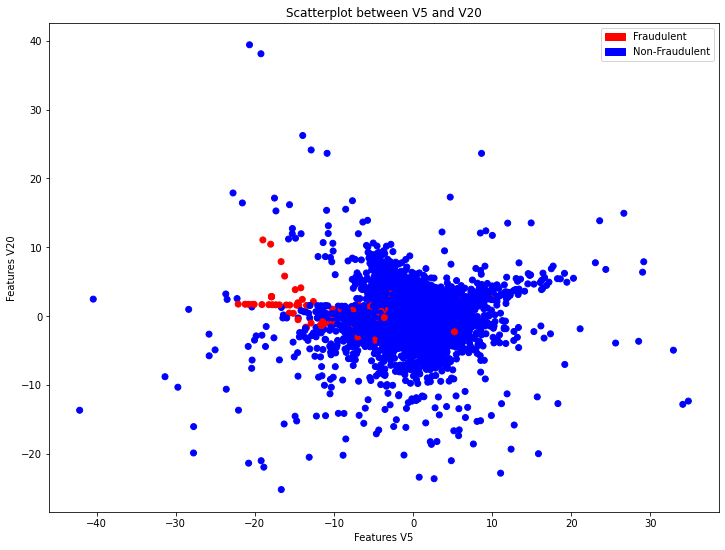

In [44]:
# Third Pair: Pick Feature V5 and V20
X_520 = X_train.iloc[:,[5,20]]
X_val_520 = X_val.iloc[:,[5,20]]

# Plot Scatter Plot 
col = np.where(y_train_new == 1,'r','b')

plt.figure(figsize=(12,9))

plt.scatter(X_520['V5'],X_520['V20'],c = col)

pop_a = mpatches.Patch(color='r', label='Fraudulent')
pop_b = mpatches.Patch(color='b', label='Non-Fraudulent')

plt.legend(handles=[pop_a,pop_b])

plt.title('Scatterplot between V5 and V20')
plt.xlabel('Features V5')
plt.ylabel('Features V20')

plt.show()

The points spread over the plot. It is hard to distinguish the clusters. I could only find one obvious cluster around $V5=0$ and $V20=0$. Hence, choose *n_components=1*.

In [45]:
Pair3 = function(X_520,X_val_520,y_val,1)

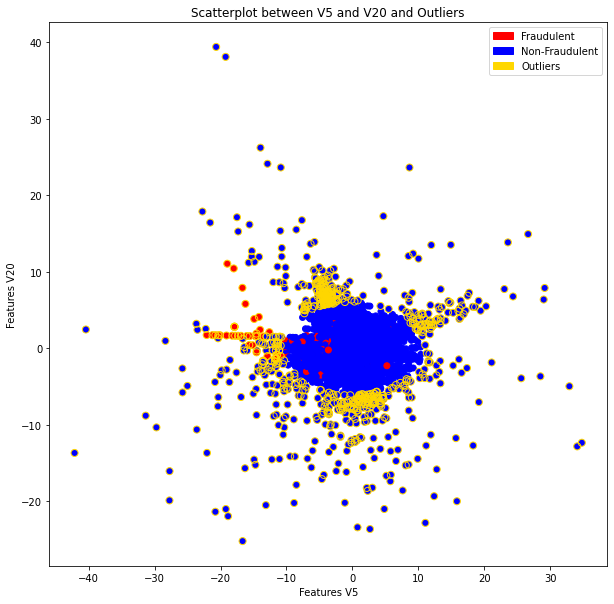

In [46]:
outliers = np.nonzero(Pair3[0]<Pair3[1])[0]
X_520 = np.array(X_520)

plt.figure(figsize=(10,10))

col = np.where(y_train_new == 1,'r','b')

plt.scatter(X_520[:,0],X_520[:,1],c = col)
plt.scatter(X_520[outliers,0],X_520[outliers,1],marker="o",facecolor= "none",edgecolor="gold",s=50)

pop_a = mpatches.Patch(color='r', label='Fraudulent')
pop_b = mpatches.Patch(color='b', label='Non-Fraudulent')
pop_c = mpatches.Patch(color='gold', label='Outliers')

plt.legend(handles=[pop_a,pop_b,pop_c])

plt.title('Scatterplot between V5 and V20 and Outliers')
plt.xlabel('Features V5')
plt.ylabel('Features V20')

plt.show()

## **Part 4: Single feature model with two Gaussian distributions. [2 Marks]**
Now we will use two different distributions for fraudulent and non-fraudulent transactions.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **non-fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively. **[0.25]**
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the transaction is classified as a fraud. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the transaction is a fraud (the transaction belongs to the $G_2$ distribution which represents fraudulent transactions). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed. **[0.25]**
  5. Repeat the steps above for all the features. What is the best F1 Score that you get for training and validation? Which feature and what c? **[1]**

Step 1-4:

In [47]:
combined = pd.concat([X_train,y_train],axis=1)
combined1 = combined.loc[combined['Class'] == 0]
combined2 = combined.loc[combined['Class'] == 1]

In [146]:
X_train_non = combined1.iloc[:,0:30]
y_train_non = combined1.iloc[:,30]
X_train_fraud = combined2.iloc[:,0:30]
y_train_fraud = combined2.iloc[:,30]

In [147]:
# Pick Feature V16
X_train_non_16 = X_train_non.iloc[:,16]
X_train_fraud_16 = X_train_fraud.iloc[:,16]

In [148]:
X_train_non_16 = np.array(X_train_non_15).reshape(-1,1)
X_train_fraud_16 = np.array(X_train_fraud_15).reshape(-1,1)

In [149]:
X_val_16 = X_val.iloc[:,16]
X_val_16 = np.array(X_val_16).reshape(-1,1)

In [150]:
G1 = GaussianMixture(n_components=1, covariance_type = "full", random_state=0)
G1.fit(X_train_non_16)
S1 = G1.fit(X_train_non_16).score_samples(X_val_16)

In [151]:
G2 = GaussianMixture(n_components=1, covariance_type = "full", random_state=0)
G2.fit(X_train_fraud_16)
S2 = G2.fit(X_train_fraud_16).score_samples(X_val_16)

In [152]:
F1_list = []
for c in np.arange(0,10.1,0.1):
  pred_list = []
  for i in range(len(S1)):
    if S1[i] < c * S2[i]:
      pred_list.append(1)
    else:
      pred_list.append(0)
  F1_list.append(f1_score(y_val,pred_list))

F1_max = max(F1_list)
F1_index = F1_list.index(F1_max)
print(F1_index,F1_max)

52 0.58252427184466


In [154]:
A = np.arange(0,10.1,0.1)
print('When picking Feature V16,','the optimal c is', A[F1_index], ', and the maximum F1 score is', F1_max)

When picking Feature V16, the optimal c is 5.2 , and the maximum F1 score is 0.58252427184466


Step 5:

In [55]:
def function3 (x_train, x_non, x_fraud, y):
  Result=[]
  for i in range(0,29):
    x_non_new = x_non.iloc[:,i+1]
    x_non_new = np.array(x_non_new).reshape(-1,1)
    x_fraud_new = x_fraud.iloc[:,i+1]
    x_fraud_new = np.array(x_fraud_new).reshape(-1,1)
    feat = x_train.columns[i+1]
    G1 = GaussianMixture(n_components=1, 
                         covariance_type = "full", random_state=0)
    G1.fit(x_non_new)
    S1 = G1.fit(x_non_new).score_samples(x_train[[feat]])
    G2 = GaussianMixture(n_components=1, 
                         covariance_type = "full", random_state=0)
    G2.fit(x_fraud_new)
    S2 = G2.fit(x_fraud_new).score_samples(x_train[[feat]])
    F1_list = []
    A = np.arange(0,10.1,0.1)
    for c in np.arange(0,10.1,0.1):
      pred_list = []
      for j in range(len(S1)):
        if S1[j] < c * S2[j]:
          pred_list.append(1)
        else:
          pred_list.append(0)
      F1_list.append(f1_score(y, pred_list))
    F1_max = max(F1_list)
    F1_index = F1_list.index(F1_max)
    new = [i+1, A[F1_index], F1_max]
    Result.append(new)
    
  return Result

In [56]:
R_val = function3(X_val, X_train_non, X_train_fraud, y_val)

In [57]:
n1=[]
for i in range(0,29):
  n1.append(R_val[i][2])
idx = np.argmax(n1)

In [58]:
R_train = function3(X_train, X_train_non, X_train_fraud, y_train)

In [59]:
n2=[]
for i in range(0,29):
  n2.append(R_train[i][2])
idx2 = np.argmax(n1)

In [60]:
print('The best F1 score get for training set is', format(R_train[idx][2],'.3f'),'when we selected feature V'+ str(R_train[idx2][0]),
      'and optimal c equals',format(R_train[idx2][1],'.1f'))

The best F1 score get for training set is 0.640 when we selected feature V14 and optimal c equals 9.2


In [61]:
print('The best F1 score get for validation set is', format(R_val[idx][2],'.3f'),'when we selected feature V'+ str(R_val[idx][0]),
      'and optimal c equals',format(R_val[idx][1],'.1f'))

The best F1 score get for validation set is 0.644 when we selected feature V14 and optimal c equals 5.9


## **Part 5: Multivariate and Mixture of Gaussians Distribution [4 Marks]**
We now want to build an outlier detection model that performs well in terms of F1 score. To design your model, you can benefit from:

*   No restrictions on the number of features - use as few or as many as you want! (multivariate). 
*   To fit your model, you can take advantage of the Gaussian mixture model, where you can set the number of components [help](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).
*   You can choose to fit your Gaussians on non-fraudulent transactions or to both classes. 


It is up to you how to design your model. Try at least 10 different models and report the AUC for both training and validation sets (if applicable) and the best F1 score for both training and validation sets for each model. What kind of model works better? How many features are best (and which ones)? How many Gaussians? How many components? Summarize your findings with tables or plots. **[4]**


**HINT !**

You might want to try a two-gaussian model, multiple features, a single component for the valid transaction, and multiple components for fraudulent ones! Why does it make sense to have multiple components for fraudulent transactions?

I decide to form 10 models using the best features found in part2, which are V14, V12, V17.   
The first five models would be two Gaussian models,  a single component for non-fraudulent transaction and 2 components for fraudulent transactions.  
The rest models would be one Gaussian models with *n_components=1*.  
The features used in two groups of models would be in the following order:  
[V14,V12,V17], [V12,V14], [V12,V17], [V14,V17], [V14]

In [62]:
# Function for two-gaussian model
def twoGaussian (x, x_val, x_non, x_fraud, y, y_val, num1, num2):

  G1 = GaussianMixture(n_components=num1, 
                       covariance_type = "full", random_state=0)
  G1.fit(x_non)
  S1 = G1.fit(x_non).score_samples(x)
  S1_2 = G1.fit(x_non).score_samples(x_val)
    
  G2 = GaussianMixture(n_components=num2,
                       covariance_type = "full", random_state=0)
  G2.fit(x_fraud)
  S2 = G2.fit(x_fraud).score_samples(x)
  S2_2 = G2.fit(x_fraud).score_samples(x_val)
    
  F1_list = []
  A = np.arange(0,10.1,0.1)
  for c in np.arange(0,10.1,0.1):
    pred_list = []
    for j in range(len(S1)):
      if S1[j] < c * S2[j]:
        pred_list.append(1)
      else:
        pred_list.append(0)
    F1_list.append(f1_score(y, pred_list))
  F1_max = max(F1_list)
  F1_index = F1_list.index(F1_max)

  F1_list2 = []
  for c in np.arange(0,10.1,0.1):
    pred_list2 = []
    for j in range(len(S1_2)):
      if S1_2[j] < c * S2_2[j]:
        pred_list2.append(1)
      else:
        pred_list2.append(0)
    F1_list2.append(f1_score(y_val, pred_list2))
  F1_max2 = max(F1_list2)
  F1_index2 = F1_list2.index(F1_max2)
  
  return [F1_max, F1_max2]

In [63]:
# Function for one-gaussian model
def oneGaussian (x_train,x_val,y_train, y_val,num):

  gm = GaussianMixture(n_components=num,covariance_type='full',random_state=0)
  gm.fit(x_train)

  sc = gm.fit(x_train).score_samples(x_train)
  sc_val = gm.fit(x_train).score_samples(x_val)

  fpr_sc, tpr_sc, _ = roc_curve(y_train, 1-sc)
  fpr_sc_val, tpr_sc_val,_ = roc_curve(y_val, 1-sc_val)

  auc_train = auc(fpr_sc, tpr_sc)
  auc_val = auc(fpr_sc_val, tpr_sc_val)

  F1_list1000 = []

  for i in range(1,len(sc),1000):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_train,new_list)
    F1_list1000.append(F1)
  
  F1_max1000 = max(F1_list1000)
  F1_index1000 = F1_list1000.index(F1_max1000)

  F1_list100 = []

  for i in range(1,F1_index1000*1000+1,100):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_train,new_list)
    F1_list100.append(F1)
  
  F1_max100 = max(F1_list100)
  F1_index100 = F1_list100.index(F1_max100)

  F1_list10 = []

  for i in range(1,F1_index100*100+1,10):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_train,new_list)
    F1_list10.append(F1)
  
  F1_max10 = max(F1_list10)
  F1_index10 = F1_list10.index(F1_max10)
  
  F1_list = []

  for i in range(1,F1_index10*10+1):
    mn_sc = sorted(sc)[i]
    new_list=[]
    for j in range(0,len(sc)):
      if sc[j] < mn_sc:
        new_list.append(1)
      else:
        new_list.append(0) 
    F1 = f1_score(y_train,new_list)
    F1_list.append(F1)
  
  F1_max = max(F1_list)
  F1_index = F1_list.index(F1_max)

  F1_list2000 = []

  for i in range(1,len(sc_val),1000):
    mn_sc_val = sorted(sc_val)[i]
    new_list2=[]
    for j in range(0,len(sc_val)):
      if sc_val[j] < mn_sc_val:
        new_list2.append(1)
      else:
        new_list2.append(0) 
    F1_2 = f1_score(y_val,new_list2)
    F1_list2000.append(F1_2)
  
  F1_max2000 = max(F1_list2000)
  F1_index2000 = F1_list2000.index(F1_max2000)

  F1_list200 = []

  for i in range(1,F1_index2000*1000+1,100):
    mn_sc_val = sorted(sc_val)[i]
    new_list2=[]
    for j in range(0,len(sc_val)):
      if sc_val[j] < mn_sc_val:
        new_list2.append(1)
      else:
        new_list2.append(0) 
    F1_2 = f1_score(y_val,new_list2)
    F1_list200.append(F1_2)
  
  F1_max200 = max(F1_list200)
  F1_index200 = F1_list200.index(F1_max200)

  F1_list20 = []

  for i in range(1,F1_index200*100+1,10):
    mn_sc_val = sorted(sc_val)[i]
    new_list2=[]
    for j in range(0,len(sc_val)):
      if sc_val[j] < mn_sc_val:
        new_list2.append(1)
      else:
        new_list2.append(0) 
    F1_2 = f1_score(y_val,new_list2)
    F1_list20.append(F1_2)
  
  F1_max20 = max(F1_list20)
  F1_index20 = F1_list20.index(F1_max20)
  
  F1_list2 = []

  for i in range(1,F1_index20*10+1):
    mn_sc_val = sorted(sc_val)[i]
    new_list2=[]
    for j in range(0,len(sc_val)):
      if sc_val[j] < mn_sc_val:
        new_list2.append(1)
      else:
        new_list2.append(0) 
    F1_2 = f1_score(y_val,new_list2)
    F1_list2.append(F1_2)
  
  F1_max2 = max(F1_list2)
  F1_index2 = F1_list2.index(F1_max2)

  return [[auc_train,F1_max],[auc_val,F1_max2]]

In [64]:
combined = pd.concat([X_train,y_train],axis=1)
combined1 = combined.loc[combined['Class'] == 0]
combined2 = combined.loc[combined['Class'] == 1]
X_train_non = combined1.iloc[:,0:30]
y_train_non = combined1.iloc[:,30]
X_train_fraud = combined2.iloc[:,0:30]
y_train_fraud = combined2.iloc[:,30]

In [65]:
# Model 1
X_m1_non = X_train_non.iloc[:,[12,14,17]]
X_m1_fraud= X_train_fraud.iloc[:,[12,14,17]]
X_val_m1 = X_val.iloc[:,[12,14,17]]
X_train_m1 = X_train.iloc[:,[12,14,17]]

Model1 = twoGaussian(X_train_m1,X_val_m1,X_m1_non,X_m1_fraud,y_train,y_val,1,2)
Model1

[0.7864506627393225, 0.7833333333333334]

In [66]:
# Model 2
X_m2_non = X_train_non.iloc[:,[12,14]]
X_m2_fraud= X_train_fraud.iloc[:,[12,14]]
X_val_m2 = X_val.iloc[:,[12,14]]
X_train_m2 = X_train.iloc[:,[12,14]]

Model2 = twoGaussian(X_train_m2,X_val_m2,X_m2_non,X_m2_fraud,y_train,y_val,1,2)
Model2

[0.7630402384500745, 0.717557251908397]

In [67]:
# Model 3
X_m3_non = X_train_non.iloc[:,[12,17]]
X_m3_fraud= X_train_fraud.iloc[:,[12,17]]
X_val_m3 = X_val.iloc[:,[12,17]]
X_train_m3 = X_train.iloc[:,[12,17]]

Model3 = twoGaussian(X_train_m3,X_val_m3,X_m3_non,X_m3_fraud,y_train,y_val,1,2)
Model3

[0.7160883280757099, 0.7086614173228346]

In [68]:
# Model 4
X_m4_non = X_train_non.iloc[:,[14,17]]
X_m4_fraud= X_train_fraud.iloc[:,[14,17]]
X_val_m4 = X_val.iloc[:,[14,17]]
X_train_m4 = X_train.iloc[:,[14,17]]

Model4 = twoGaussian(X_train_m4,X_val_m4,X_m4_non,X_m4_fraud,y_train,y_val,1,2)
Model4

[0.758308157099698, 0.7804878048780488]

In [69]:
# Model 5
X_m5_non = X_train_non.iloc[:,[14]]
X_m5_fraud= X_train_fraud.iloc[:,[14]]
X_val_m5 = X_val.iloc[:,[14]]
X_train_m5 = X_train.iloc[:,[14]]

X_m5_non = np.array(X_m5_non).reshape(-1,1)
X_m5_fraud = np.array(X_m5_fraud).reshape(-1,1)

Model5 = twoGaussian(X_train_m5,X_val_m5,X_m5_non,X_m5_fraud,y_train,y_val,1,2)
Model5

[0.6399999999999999, 0.6438356164383563]

In [70]:
# Model 6
X_val_m6 = X_val.iloc[:,[12,14,17]]
X_train_m6 = X_train.iloc[:,[12,14,17]]

Model6 = oneGaussian(X_train_m6,X_val_m6,y_train,y_val,1)
Model6

[[0.9587484152992161, 0.7079136690647481],
 [0.9535102740363183, 0.6901408450704225]]

In [71]:
# Model 7
X_val_m7 = X_val.iloc[:,[12,14]]
X_train_m7 = X_train.iloc[:,[12,14]]

Model7 = oneGaussian(X_train_m7,X_val_m7,y_train,y_val,1)
Model7

[[0.956719998295781, 0.6865248226950355],
 [0.957666624247336, 0.6407766990291262]]

In [72]:
# Model 8
X_val_m8 = X_val.iloc[:,[12,17]]
X_train_m8 = X_train.iloc[:,[12,17]]

Model8 = oneGaussian(X_train_m8,X_val_m8,y_train,y_val,1)
Model8

[[0.949575399626275, 0.6708074534161491],
 [0.9366452411836631, 0.6206896551724137]]

In [73]:
# Model 9
X_val_m9 = X_val.iloc[:,[14,17]]
X_train_m9 = X_train.iloc[:,[14,17]]

Model9 = oneGaussian(X_train_m9,X_val_m9,y_train,y_val,1)
Model9

[[0.9599173906707736, 0.690856313497823],
 [0.9599647100936425, 0.6917293233082706]]

In [74]:
# Model 10
X_val_m10 = X_val.iloc[:,[14]]
X_train_m10 = X_train.iloc[:,[14]]

X_val_m10 = np.array(X_val_m10).reshape(-1,1)
X_train_m10 = np.array(X_train_m10).reshape(-1,1)

Model10 = oneGaussian(X_train_m10,X_val_m10,y_train,y_val,1)
Model10

[[0.9497395368699795, 0.6046511627906976],
 [0.9552970953177244, 0.6218487394957983]]

In [75]:
colnames = ['AUC of Training Set','AUC of Validation Set',
            'Best F1 Score of Training Set','Best F1 Score of Validation Set']
indices = ['Model' + str(i) for i in range(1,11)]
D = pd.DataFrame(columns=colnames,index=indices)

In [76]:
Gaussian2 = [Model1,Model2,Model3,
               Model4,Model5]
F1_train = [item[0] for item in Gaussian2]
F1_val = [item[1] for item in Gaussian2]

In [77]:
Gaussian1_train = [Model6[0],Model7[0],Model8[0],
                   Model9[0],Model10[0]]
AUC_train = [None] * 9
AUC_train[5:9] = [item[0] for item in Gaussian1_train]
F1_train.extend([item[1] for item in Gaussian1_train])

In [78]:
Gaussian1_val = [Model6[1],Model7[1],Model8[1],
                   Model9[1],Model10[1]]
AUC_val = [None] * 9
AUC_val[5:9] = [item[0] for item in Gaussian1_val]
F1_val.extend([item[1] for item in Gaussian1_val])

In [79]:
D['AUC of Training Set']=AUC_train
D['AUC of Validation Set']=AUC_val
D['Best F1 Score of Training Set']=F1_train
D['Best F1 Score of Validation Set']=F1_val

In [162]:
print(tabulate(D,tablefmt='markdown', headers="keys"))

           AUC of Training Set    AUC of Validation Set    Best F1 Score of Training Set    Best F1 Score of Validation Set
-------  ---------------------  -----------------------  -------------------------------  ---------------------------------
Model1              nan                      nan                                0.786451                           0.783333
Model2              nan                      nan                                0.76304                            0.717557
Model3              nan                      nan                                0.716088                           0.708661
Model4              nan                      nan                                0.758308                           0.780488
Model5              nan                      nan                                0.64                               0.643836
Model6                0.958748                 0.95351                          0.707914                           0.690141
Model7  

From the above table, we can see that Two Gaussian Model works better than One Gaussian model as the F1 score of validation set are higher.  
From the table, Model 1 has the highest F1 score for validation set, so Model 1 works better than other models. Model 1 is a Two Gaussian Model with 3 Features which are V14, V12, V17. And the number of components for non-fraudulent set is 1 and the number of components for fraudulent transactions is 2.  

## **Part 6: Evaluating performance on test set: [1 Mark]**
**Which model worked better?** Pick your best model among all models and apply it to your test set. Report the F1 Score, precision and recall on the test set. **[1]**


In [81]:
print('The model with highest F1 Score for Training Set is', 
      D.index[np.argmax(D['Best F1 Score of Training Set'])])

The model with highest F1 Score for Training Set is Model1


In [82]:
print('The model with highest F1 Score for Validation Set is',
      D.index[np.argmax(D['Best F1 Score of Validation Set'])])

The model with highest F1 Score for Validation Set is Model1


Among all ten models, Model1 works better as it has higher F1 scores for both training set and validation set. That proves Model 1 has a better ability to distinguish non-fraudulent and fraudulent transactions.  

In [83]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [84]:
combined = pd.concat([X_test,y_test],axis=1)
combined1 = combined.loc[combined['Class'] == 0]
combined2 = combined.loc[combined['Class'] == 1]
X_test_non = combined1.iloc[:,0:30]
y_test_non = combined1.iloc[:,30]
X_test_fraud = combined2.iloc[:,0:30]
y_test_fraud = combined2.iloc[:,30]

In [85]:
X_test_non = X_test_non.iloc[:,[12,14,17]]
X_test_fraud= X_test_fraud.iloc[:,[12,14,17]]
X_test_m1 = X_test.iloc[:,[12,14,17]]

In [86]:
G1 = GaussianMixture(n_components=1, 
                       covariance_type = "full", random_state=0)
G1.fit(X_test_non)
S1 = G1.fit(X_test_non).score_samples(X_test_m1)
    
G2 = GaussianMixture(n_components=2,
                       covariance_type = "full", random_state=0)
G2.fit(X_test_fraud)
S2 = G2.fit(X_test_fraud).score_samples(X_test_m1)

In [87]:
F1_list = []
A = np.arange(0,10.1,0.1)
for c in np.arange(0,10.1,0.1):
  pred_list = []
  for j in range(len(S1)):
    if S1[j] < c * S2[j]:
      pred_list.append(1)
    else:
      pred_list.append(0)
  F1_list.append(f1_score(y_test, pred_list))

F1_max = max(F1_list)
F1_index = F1_list.index(F1_max)

format(A[F1_index],'.1f')

'7.1'

In [88]:
pred_list = []
for j in range(len(S1)):
  if S1[j] < 7.1 * S2[j]:
    pred_list.append(1)
  else:
    pred_list.append(0)
precision = precision_score(y_test, pred_list)
recall = recall_score(y_test, pred_list)

In [89]:
[precision,recall,F1_max]

[0.8571428571428571, 0.7297297297297297, 0.7883211678832117]

In [90]:
print('The F1 score of the test set is', format(F1_max,'.4f'), '; and the precision is', format(precision,'.4f'),
      'and the recall is', format(recall,'.4f'))

The F1 score of the test set is 0.7883 ; and the precision is 0.8571 and the recall is 0.7297


## **Part 7: Is Gaussian the only useful distribution? [1 Mark]**

Search for other distributions that could be used to model the data. How popular are they? Is there a specific situation where a distribution works better? How can we find a suitable distribution to model our data? Do not forget to include your references. 




Logistic Regression and Isolation Forest are both popular algorithm for anmaly detection and both can be used to model the data$^1$.   
Isolation Forest is the first anomaly detection algorithm. In high dimensional problems with a large number of irrelevant attributes and in suitations the training set does not contain any anomalies, isolation forest works well.$^2$  
Logistic Regression is a commonly known statistical model and can deal with the data which has a binary response. There are three types of logistic regression: Binomial(whether dependent variable are dualistic), multinomial(where dependent variables have three or more unordered types) and ordinal(where dependent variables have three or more ordered types)$^3$. Multinomial logistic regression are usually used in fraud detection.  
We can use Confusion Matrix to calculate the accuracy of logistic regression models, and determine the effeciency of the models through the accuracy$^4$. Also, the accuracy of Isolation Forest can be calculated by finding how many outlier the model found divided by how many outliers present in the data$^5$.  
Furthermore, we can always using testing set to test our models on the capacity in generating with data unseen.  

References:
1. https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/
2. https://en.wikipedia.org/wiki/Isolation_forest#Anomaly_detection_with_isolation_forest
3. https://www.javatpoint.com/logistic-regression-in-machine-learning
4. https://www.kaggle.com/gauravduttakiit/creditcard-fraud-detection-by-logistic-regression
5. https://medium.com/analytics-vidhya/testers-guide-for-testing-machine-learning-models-e7e5cea81264
